In [1]:
from pyspark.sql import *
import pandas as pd

In [2]:
spark = SparkSession\
            .builder\
            .appName("books-app")\
            .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/04 20:03:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("./Sales_Data/Books_rating.csv", 
                            header="true",
                            inferSchema="true")
df.createOrReplaceTempView("books_rating")
df.schema

StructType([StructField('Id', StringType(), True), StructField('Title', StringType(), True), StructField('Price', StringType(), True), StructField('User_id', StringType(), True), StructField('profileName', StringType(), True), StructField('review/helpfulness', StringType(), True), StructField('review/score', StringType(), True), StructField('review/time', StringType(), True), StructField('review/summary', StringType(), True), StructField('review/text', StringType(), True)])

In [4]:
sql = """
SELECT Title, AVG(`review/score`) as average_score
FROM books_rating
GROUP BY Title
"""
query = spark.sql(sql)
query.toPandas()

Title  average_score
0       Isaac Asimov: Master of Science Fiction (Peopl...       2.500000
1                                         White Rock Ways       5.000000
2                             The Face of the Third Reich       5.000000
3       Your Signature Life: Pursuing God's Best Every...       5.000000
4                                         Iridescent Soul       4.750000
...                                                   ...            ...
212395                  Esther (Spanish language edition)       5.000000
212396  Plastic Part Design for Injection Molding : An...       4.285714
212397  Body Scan: Managing Pain, Illness, & Stress wi...       4.571429
212398                            The Roald Dahl Treasury       4.444444
212399                                   Beauty for ashes       5.000000

[212400 rows x 2 columns]

In [5]:
sql = """
SELECT Title, FLOAT(`Price`), AVG(`review/score`) as average_score
FROM books_rating
GROUP BY Title, Price
"""
query = spark.sql(sql)
query.toPandas()

Title      Price  \
0       Florida Birds: An Introduction to Familiar Spe...   5.950000   
1       Jambalaya: Hal Leonard Student Piano Library C...   9.990000   
2                Pokemon - 2.B.A. Master: Piano Fun! Pack  19.950001   
3          International Law Anthology (Anthology Series)  29.000000   
4                          From Fear to Hope & Back Again   9.940000   
...                                                   ...        ...   
214416      Seven came through: Rickenbacker's full story        NaN   
214417  Plastic Part Design for Injection Molding : An...        NaN   
214418  Body Scan: Managing Pain, Illness, & Stress wi...        NaN   
214419                            The Roald Dahl Treasury        NaN   
214420                                   Beauty for ashes        NaN   

        average_score  
0            3.666667  
1            5.000000  
2            3.000000  
3            5.000000  
4            4.750000  
...               ...  
214416       4.000000  
214417       4.285714  
214418       4.571429  
214419       4.444444  
214420       5.000000  

[214421 rows x 3 columns]

### The following is data where Price and Title labels are not missing

In [6]:
sql = """
SELECT Title, FLOAT(`Price`), FLOAT(AVG(`review/score`)) as average_score
FROM books_rating
WHERE Title IS NOT NULL
    AND `review/score` > 0
    AND Price > 0
GROUP BY Title, Price
"""
data = spark.sql(sql)
data.toPandas()

Title      Price  \
0      Florida Birds: An Introduction to Familiar Spe...   5.950000   
1      Jambalaya: Hal Leonard Student Piano Library C...   9.990000   
2               Pokemon - 2.B.A. Master: Piano Fun! Pack  19.950001   
3         International Law Anthology (Anthology Series)  29.000000   
4                         From Fear to Hope & Back Again   9.940000   
...                                                  ...        ...   
48899  Sexual Liberation or Sexual License?: The Amer...  24.950001   
48900                                 Wystan and Chester  75.000000   
48901  How to Stop Heartburn: Simple Ways to Heal Hea...   3.190000   
48902  Smithsonian Handbooks: Birds of North America ...  19.799999   
48903             Bitter/Sweet 2: The Drama Continues...  13.500000   

       average_score  
0           3.666667  
1           5.000000  
2           3.000000  
3           5.000000  
4           4.750000  
...              ...  
48899       2.750000  
48900       3.000000  
48901       4.062500  
48902       4.263158  
48903       5.000000  

[48904 rows x 3 columns]

### Getting date where price is missing

In [7]:
sql = """
SELECT Title, FLOAT(`Price`), FLOAT(AVG(`review/score`)) as average_score
FROM books_rating
WHERE Title IS NOT NULL
    AND `review/score` > 0
    AND Price IS NULL
GROUP BY Title, Price
"""
to_predict = spark.sql(sql).toPandas()
to_predict

Title  Price  \
0       Isaac Asimov: Master of Science Fiction (Peopl...    NaN   
1                                         White Rock Ways    NaN   
2                             The Face of the Third Reich    NaN   
3       Your Signature Life: Pursuing God's Best Every...    NaN   
4                                         Iridescent Soul    NaN   
...                                                   ...    ...   
164855      Seven came through: Rickenbacker's full story    NaN   
164856  Plastic Part Design for Injection Molding : An...    NaN   
164857  Body Scan: Managing Pain, Illness, & Stress wi...    NaN   
164858                            The Roald Dahl Treasury    NaN   
164859                                   Beauty for ashes    NaN   

        average_score  
0            2.500000  
1            5.000000  
2            5.000000  
3            5.000000  
4            4.750000  
...               ...  
164855       4.000000  
164856       4.285714  
164857       4.571429  
164858       4.444445  
164859       5.000000  

[164860 rows x 3 columns]

In [8]:
query.toPandas().isna().sum()

Title                 4
Price            165411
average_score       650
dtype: int64

In [9]:
data.toPandas().isna().sum()

Title            0
Price            0
average_score    0
dtype: int64

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

### Visualize missing data for original dataset

In [12]:
sns.heatmap(query.toPandas().isnull(),yticklabels=False,cbar=False,cmap='viridis')  

<AxesSubplot: >

In [13]:
to_predict.isna().sum()

Title                 0
Price            164860
average_score         0
dtype: int64

<AxesSubplot: >

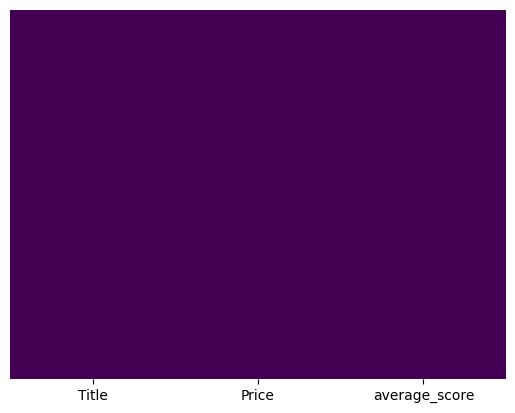

In [14]:
sns.heatmap(data.toPandas().isnull(),yticklabels=False,cbar=False,cmap='viridis')  

<AxesSubplot: >

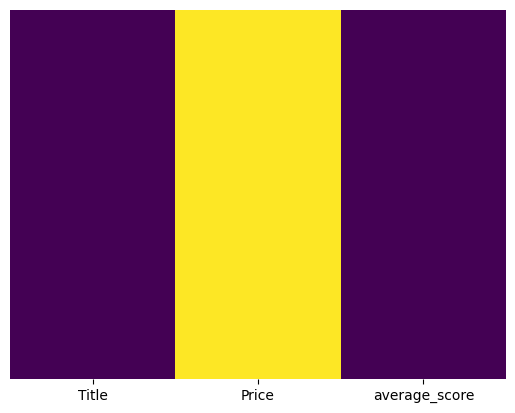

In [15]:
sns.heatmap(to_predict.isnull(),yticklabels=False,cbar=False,cmap='viridis')  

/tmp/ipykernel_692/3729749066.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.toPandas().corr()


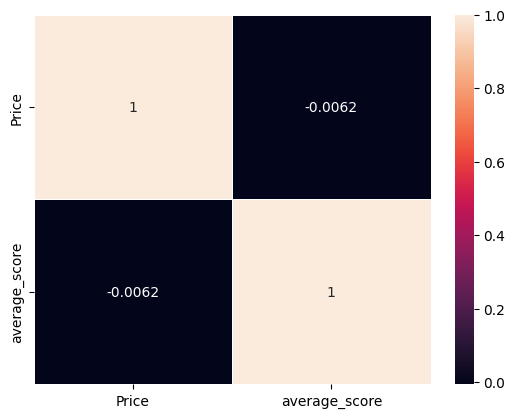

In [16]:
corr = data.toPandas().corr()
sns.heatmap(corr, annot=True, linewidths=0.5)
plt.show()

/tmp/ipykernel_692/1206710873.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=data.toPandas(), x=data.toPandas()['Price'], y=data.toPandas()['average_score'], # hue=another_data['stroke'],


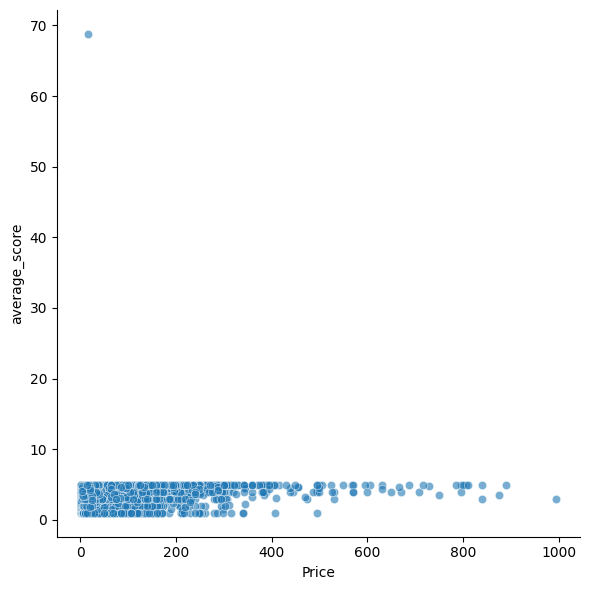

In [17]:
sns.relplot(data=data.toPandas(), x=data.toPandas()['Price'], y=data.toPandas()['average_score'], # hue=another_data['stroke'],
            palette=["r", "b"], sizes=( 100), alpha=.6, height=6,
            style_order=[data.toPandas()['Price'], data.toPandas()['average_score']]
           )